In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches

import os
import math
import random

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, auc

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d
from scipy.stats import norm
from scipy.stats import multivariate_normal

import xgboost
from xgboost import XGBRegressor, XGBClassifier

### Gaussian example

In [20]:
##############
# PARAMETERS #
##############

# gaussian, mean
epsilon = 0.3

# dataset, number of events
N = 1500000

# requested number of ensembles
n_ensembles = 2000

# number of expected background events per ensemble
B_expected = 50000

# S_expected:
S_expected = [100, 500, 1000]



# SOME USEFUL DERIVATED PARAMETERS:

# S/\sqrt{B}
SsqrtB = [i/(B_expected**0.5) for i in S_expected]

### dim=3

In [6]:
dim=3

#######################
# generate the events #
#######################
    
mean_sig = epsilon*np.ones(dim)
mean_bkg = -1*mean_sig

#cov_sig = np.identity(dim)
cov_sig = np.identity(dim) + (0. * ( np.ones((dim,dim)) - np.identity(dim) ))
cov_bkg = cov_sig

signal_X_1, signal_X_2, signal_X_3 = np.random.multivariate_normal(mean_sig, cov_sig, N).T
background_X_1, background_X_2, background_X_3 = np.random.multivariate_normal(mean_bkg, cov_bkg, N).T

dim1 = np.concatenate((background_X_1,signal_X_1))
dim2 = np.concatenate((background_X_2,signal_X_2))
dim3 = np.concatenate((background_X_3,signal_X_3))

# labels
background_Y = np.zeros(N)
signal_Y = np.ones(N)

# DATA in a single matrix (features + labels)
df = pd.DataFrame()
df['dim1'] = dim1.reshape(-1)
df['dim2'] = dim2.reshape(-1)
df['dim3'] = dim3.reshape(-1)
df['Y'] = np.concatenate((background_Y.astype('int'),signal_Y.astype('int')))

X_mon = df[['dim1','dim2','dim3']].values 
y_mon = df[['Y']].values

# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25

X_mon_aux, X_mon_test, y_mon_aux, y_mon_test = train_test_split(X_mon,
                                                                y_mon,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon,
                                                                shuffle=True)


X_mon_train, X_mon_val, y_mon_train, y_mon_val = train_test_split(X_mon_aux,
                                                                  y_mon_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon_aux,
                                                                  shuffle=True)

print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')


X_mon_train :  (1500000, 3)
y_mon_train :  (1500000, 1)
X_mon_val :  (500000, 3)
y_mon_val :  (500000, 1)
X_mon_test :  (1000000, 3)
y_mon_test :  (1000000, 1)



### XGBoost

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.67556	validation_1-logloss:0.67572
[1]	validation_0-logloss:0.66101	validation_1-logloss:0.66125
[2]	validation_0-logloss:0.64879	validation_1-logloss:0.64915
[3]	validation_0-logloss:0.63843	validation_1-logloss:0.63887
[4]	validation_0-logloss:0.62969	validation_1-logloss:0.63015
[5]	validation_0-logloss:0.62220	validation_1-logloss:0.62276
[6]	validation_0-logloss:0.61578	validation_1-logloss:0.61647
[7]	validation_0-logloss:0.61032	validation_1-logloss:0.61105
[8]	validation_0-logloss:0.60560	validation_1-logloss:0.60638
[9]	validation_0-logloss:0.60153	validation_1-logloss:0.60239
[10]	validation_0-logloss:0.59800	validation_1-logloss:0.59891
[11]	validation_0-logloss:0.59495	validation_1-logloss:0.59593
[12]	validation_0-logloss:0.59227	validation_1-logloss:0.59332
[13]	validation_0-logloss:0.58995	validation_1-logloss:0.59105
[14]	validation_0-logloss:0.58792	validation_1-logloss:0.58908
[15]	validation_0-logloss:0.58615	validation_1-logloss:0.58735
[1

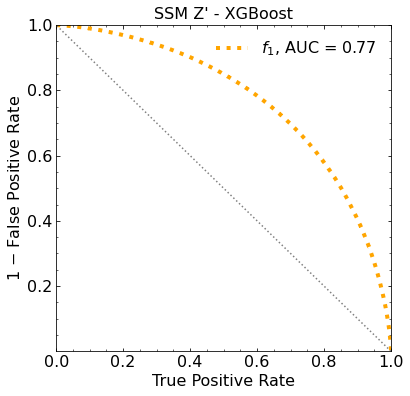

In [7]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=1500,
    learning_rate=0.1,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5)

# FIT
classifier.fit(X_mon_train,y_mon_train,eval_set=[(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
        eval_metric='logloss',early_stopping_rounds=50,#early stopping
        verbose=True)

# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]


# ROC
fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg)
roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.title(r"SSM Z' - XGBoost",fontsize=16)
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()

Classification score:


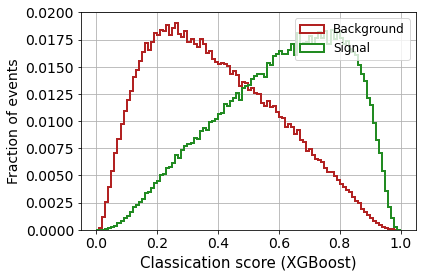

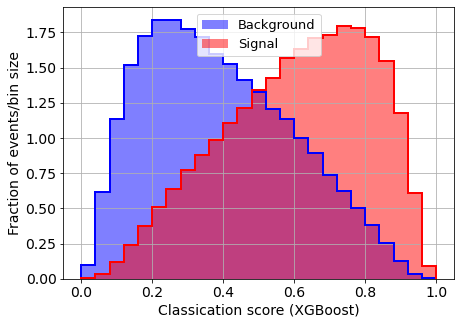

In [11]:
########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 100, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 100, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)
#plt.savefig('images/' + '2monian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()



plt.figure(figsize=(7,5))

nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 25, range=[0,1], density=True, histtype='step', color='blue', linewidth=2)#, label='Background')
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 25, range=[0,1], density=True, histtype='step', color='red', linewidth=2)#, label='Signal')

nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 25, range=[0,1], density=True, color='blue',alpha=0.5, linewidth=2, label='Background')
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 25, range=[0,1], density=True, color='red',alpha=0.5, linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.yscale('log')
plt.xlabel("Classication score (XGBoost)",fontsize=14)
plt.ylabel("Fraction of events/bin size",fontsize=14)
plt.grid()
plt.legend(loc='upper center',fontsize=13)
# plt.title(r'$m(LQ_3^u)=1.2$ TeV, $\beta=0.5$', fontsize=14)
#plt.savefig('XG_output.pdf', format="pdf", bbox_inches="tight")
plt.show()

## BIN LIKELIHOOD

### Max number of bins

In [18]:
# MINIMUM NUMBER OF EVENTS PER BIN THAT WE ALLOW
MIN_EVS = 5




# Les't find the number of possible ensembles
N_ensembles_back = int(len(pred_XG_SM) / B_expected)
N_events_back = N_ensembles_back * B_expected


for bin_it in range(10,500):
    # bin the parameter space of all background events
    hist_back, binedges_back = np.histogramdd([pred_XG_SM[:N_events_back]], bins=(bin_it), range = [[0,1]])

    if min(hist_back) <= MIN_EVS * N_ensembles_back:
        print('At least ' + str(MIN_EVS) + ' B events per bin, range = [[0,1]]:')
        print('# bins: ',bin_it+1,'ok')
        break
        
print('')

for bin_it in range(10,500):
    # bin the parameter space of all background events
    hist_back, binedges_back = np.histogramdd([pred_XG_SM[:N_events_back]], bins=(bin_it), range = [[min(pred_XG_SM[:N_events_back]),max(pred_XG_SM[:N_events_back])]])

    if min(hist_back) <= MIN_EVS * N_ensembles_back:
        print('At least ' + str(MIN_EVS) + ' B events per bin, range = [[min(B),max(B)]]:')
        print('# bins: ',bin_it+1,'ok')
        break

At least 5 B events per bin, range = [[0,1]]:
# bins:  28 ok

At least 5 B events per bin, range = [[min(B),max(B)]]:
# bins:  43 ok


### Bin Likelihood test

B_expected:  50000
S_expected:  100
S/$\sqrt{B}$:  0.4472135954999579


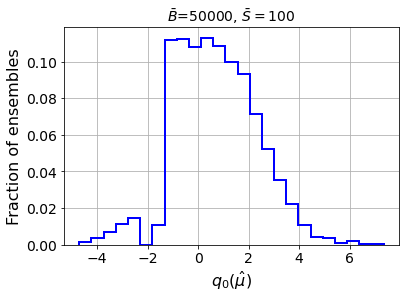

bins:  16
muhat mean:  0.030850000000000002
median q_muhat_16bins:  0.6178491903550096
Z_16bins:  0.7860338353754307
Z_16bins mu=0:  0.7860338353754307
std Z_16bins:  0.7670262402965629
std Z_16bins mu=0:  0.7670262402965629


 -------------------------------- 

B_expected:  50000
S_expected:  500
S/$\sqrt{B}$:  2.23606797749979


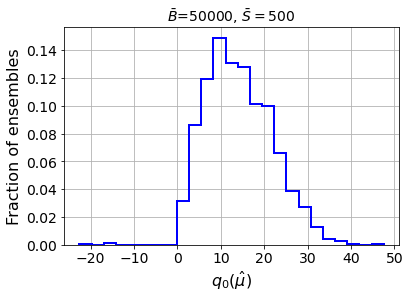

bins:  16
muhat mean:  0.10017500000000001
median q_muhat_16bins:  13.406261558456919
Z_16bins:  3.661456207365714
Z_16bins mu=0:  3.661456207365714
std Z_16bins:  1.0272577977479007
std Z_16bins mu=0:  1.1047588780237674


 -------------------------------- 

B_expected:  50000
S_expected:  1000
S/$\sqrt{B}$:  4.47213595499958


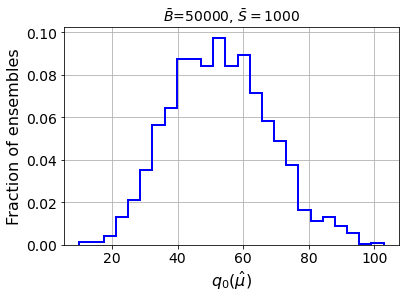

bins:  16
muhat mean:  0.0626
median q_muhat_16bins:  52.570546594146556
Z_16bins:  7.250554916290653
Z_16bins mu=0:  7.250554916290653
std Z_16bins:  1.0371935396592342
std Z_16bins mu=0:  1.1010147493945341


 -------------------------------- 

[0.030850000000000002, 0.10017500000000001, 0.0626]
[0.7860338353754307, 3.661456207365714, 7.250554916290653]
[0.7670262402965629, 1.0272577977479007, 1.0371935396592342]
[0.7860338353754307, 3.661456207365714, 7.250554916290653]
[0.7670262402965629, 1.1047588780237674, 1.1010147493945341]
[1.5530600756719934, 4.688714005113615, 8.287748455949888]
[0.019007595078867845, 2.6341984096178135, 6.213361376631419]


In [21]:
#################################
# BINNED POISSON LOG-LIKELIHOOD #
#################################

store_muhat_mean_16bins_q  = []

store_Z_bins_XG_16bins_q = []
store_Z_bins_XG_16bins_q_std = []

store_Z_bins_XG_16bins_q_mu0 = []
store_Z_bins_XG_16bins_q_std_mu0 = []




hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(16), range = [[0,1]])
bin_edges = binedges_back[0]
back_prom_16bins = hist_back.T.ravel() / (len(pred_XG_SM) / B_expected)

# find the minimum
back_prom_noceros = []
for i in range(len(back_prom_16bins)):
    if back_prom_16bins[i]!=0:
        back_prom_noceros.append(back_prom_16bins[i])

min_back = min(back_prom_noceros)

# replace the zeros
for i in range(len(back_prom_16bins)):
    if back_prom_16bins[i]==0:
        back_prom_16bins[i] = min_back
        
        






for iii in range(len(S_expected)):

    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected[iii])
    print(r'S/$\sqrt{B}$: ', SsqrtB[iii])
    

    hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=(16), range = [[0,1]])
    sig_prom_16bins = hist_sig.T.ravel() / (len(pred_XG_NP) / S_expected[iii])
    
    
    #############################
    # NOW LETS APPLY THE METHOD #
    #############################

    muhat_selected_16bins_list = []
    q_muhat_16bins = []
    q_muhat_16bins_mu0 = []
    
    
    for its in range(n_ensembles):
        
        B_rand = np.random.poisson(int(B_expected))
#         S_rand = np.random.poisson(int(S_expected[iii]))

        N_rand = B_rand # for exclusion
#         N_rand = B_rand + S_rand # for discovery
        
        pred_XG_SM_shuf = np.random.choice(pred_XG_SM, size = np.random.poisson(B_rand), replace = False)
#         pred_XG_NP_shuf = np.random.choice(pred_XG_NP, size = np.random.poisson(S_rand), replace = False)



        ############
        # 16 bins #
        ############

        # Let's find out the expected number of B and S events in each bin:

        # bin the parameter space of all background events
        hist_N, binedges_N = np.histogramdd([pred_XG_SM_shuf], bins=(16), range = [[0,1]])
        # now divide by the number of possible ensembles
        N_pseudo = hist_N.T.ravel()
        
        if min(N_pseudo) >= MIN_EVS:
        
            sum_muhat_zero = sum ( [((ni*si) / ((0.*si) + bi)) - si for ni, si, bi in zip(N_pseudo, sig_prom_16bins, back_prom_16bins)] )
            sum_muhat_one = sum ( [((ni*si) / ((1.*si) + bi)) - si for ni, si, bi in zip(N_pseudo, sig_prom_16bins, back_prom_16bins)] )

            # grid, mu_hat
            muhat_test = np.arange(0., 1., 0.05).tolist()

            muhat_selected_16bins = 0.0

            if sum_muhat_zero < sum_muhat_one and sum_muhat_zero < 1:

                for vv in range(len(muhat_test)):

                    mu_hat_condition_equal_1 = sum ( [((ni*si) / ((muhat_test[vv]*si) + bi)) - si for ni, si, bi in zip(N_pseudo, sig_prom_16bins, back_prom_16bins)] )

                    if mu_hat_condition_equal_1 > 1:
                        muhat_selected_16bins = muhat_test[vv]
                        break

            elif sum_muhat_zero > sum_muhat_one and sum_muhat_zero > 1:

                for vv in range(len(muhat_test)):

                    mu_hat_condition_equal_1 = sum ( [((ni*si) / ((muhat_test[vv]*si) + bi)) - si for ni, si, bi in zip(N_pseudo, sig_prom_16bins, back_prom_16bins)] )

                    if mu_hat_condition_equal_1 < 1:
                        muhat_selected_16bins = muhat_test[vv]
                        break


            muhat_selected_16bins_list.append(muhat_selected_16bins)
            
            
            q_muhat_16bins.append( -2 * sum([( (ni * np.log( ((1.*si)+bi)/((muhat_selected_16bins*si)+bi) ) ) - ((1.*si)+bi) + ((muhat_selected_16bins*si)+bi) ) for ni, si, bi in zip(N_pseudo, sig_prom_16bins, back_prom_16bins)]) )
            q_muhat_16bins_mu0.append( -2 * sum([( (ni * np.log( ((1.*si)+bi)/((0.*si)+bi) ) ) - ((1.*si)+bi) + ((0.*si)+bi) ) for ni, si, bi in zip(N_pseudo, sig_prom_16bins, back_prom_16bins)]) )

            
            
        
        
    # Histogram of q_muhats

    weights = np.ones_like(q_muhat_16bins)/float(len(q_muhat_16bins))
    nMIX, binsMIX, patchesMIX = plt.hist(q_muhat_16bins, 25, weights=weights, histtype='step', color='blue', linewidth=2)
    #plt.xlim(0,1)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
    plt.ylabel("Fraction of ensembles",fontsize=16)
    plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected[iii]),fontsize=14)
    plt.grid()
    #plt.legend(fontsize=14)
    plt.show()

    
    

    # Finally calculate muhat_mean and Z_gaussian
    
    # 16 bins #
    # Remove nan if any
    q_muhat_16bins_mu0 = [x for x in q_muhat_16bins_mu0 if x == x]
    for jk in range(len(q_muhat_16bins_mu0)):
        if q_muhat_16bins_mu0[jk] < 0:
            q_muhat_16bins_mu0[jk] = 0

    q_muhat_16bins_median_mu0 = np.median(q_muhat_16bins_mu0)
    Z_16bins_mu0 = abs(q_muhat_16bins_median_mu0)**0.5
    store_Z_bins_XG_16bins_q_mu0.append(Z_16bins_mu0)
    
    q_muhat_16bins_std_mu0 = np.std(q_muhat_16bins_mu0)
    Z_16bins_std_mu0 = q_muhat_16bins_std_mu0/(2.*Z_16bins_mu0)
    store_Z_bins_XG_16bins_q_std_mu0.append(Z_16bins_std_mu0)
    

    # Finally calculate muhat_mean and Z_gaussian
    muhat_mean_16bins = np.mean(muhat_selected_16bins_list)
    store_muhat_mean_16bins_q.append(muhat_mean_16bins)

    # Remove nan if any
    q_muhat_16bins = [x for x in q_muhat_16bins if x == x]
    for jk in range(len(q_muhat_16bins)):
        if q_muhat_16bins[jk] < 0:
            q_muhat_16bins[jk] = 0

    q_muhat_16bins_median = np.median(q_muhat_16bins)
    Z_16bins = abs(q_muhat_16bins_median)**0.5
    store_Z_bins_XG_16bins_q.append(Z_16bins)
    
    q_muhat_16bins_std = np.std(q_muhat_16bins)
    Z_16bins_std = q_muhat_16bins_std/(2.*Z_16bins)
    store_Z_bins_XG_16bins_q_std.append(Z_16bins_std)

    print('bins: ', 16)
    print('muhat mean: ', muhat_mean_16bins)
    print('median q_muhat_16bins: ', q_muhat_16bins_median)
    print('Z_16bins: ', Z_16bins)
    print('Z_16bins mu=0: ', Z_16bins_mu0)
    print('std Z_16bins: ', Z_16bins_std)
    print('std Z_16bins mu=0: ', Z_16bins_std_mu0)
    print('')
    
    

    print('\n -------------------------------- \n')
    

print(store_muhat_mean_16bins_q)

print(store_Z_bins_XG_16bins_q)
print(store_Z_bins_XG_16bins_q_std)

print(store_Z_bins_XG_16bins_q_mu0)
print(store_Z_bins_XG_16bins_q_std_mu0)



print(' ')
store_Z_bins_XG_16bins_q_plus = [i+j for i, j in zip(store_Z_bins_XG_16bins_q, store_Z_bins_XG_16bins_q_std)]
store_Z_bins_XG_16bins_q_min = [i-j for i, j in zip(store_Z_bins_XG_16bins_q, store_Z_bins_XG_16bins_q_std)]

print(store_Z_bins_XG_16bins_q_plus)
print(store_Z_bins_XG_16bins_q_min)


print(' ')
store_Z_bins_XG_16bins_q_mu0_plus = [i+j for i, j in zip(store_Z_bins_XG_16bins_q_mu0, store_Z_bins_XG_16bins_q_std_mu0)]
store_Z_bins_XG_16bins_q_mu0_min = [i-j for i, j in zip(store_Z_bins_XG_16bins_q_mu0, store_Z_bins_XG_16bins_q_std_mu0)]

print(store_Z_bins_XG_16bins_q_mu0_plus)
print(store_Z_bins_XG_16bins_q_mu0_min)

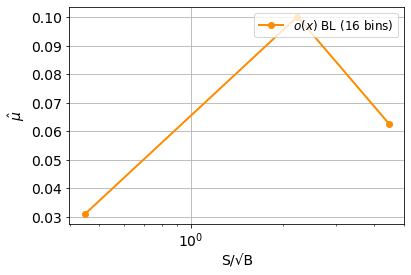

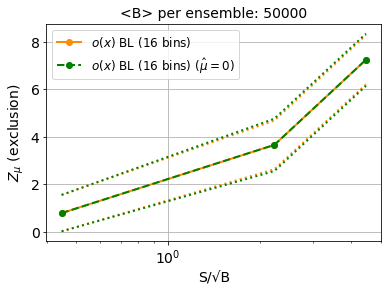

In [45]:
#########
# PLOTS #
#########


plt.figure()
lw = 2

plt.plot(SsqrtB, store_muhat_mean_16bins_q, '-o', color='darkorange', lw=lw, label=r'$o(x)$ BL (16 bins)')

#plt.xlim([0.5, 100])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=14)
plt.ylabel(r'$\hat{\mu}$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
#plt.title('Gaussian Example, <B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper right", fontsize=12)
plt.show()

    
plt.figure()
lw = 2

plt.plot(SsqrtB, store_Z_bins_XG_16bins_q, '-o', color='darkorange', lw=lw, label=r'$o(x)$ BL (16 bins)') 
plt.plot(SsqrtB, store_Z_bins_XG_16bins_q_plus, ':', color='darkorange', lw=lw) 
plt.plot(SsqrtB, store_Z_bins_XG_16bins_q_min, ':', color='darkorange', lw=lw)
plt.plot(SsqrtB, store_Z_bins_XG_16bins_q_mu0, '--o', color='green', lw=lw, label=r'$o(x)$ BL (16 bins) ($\hat{\mu}=0$)') 
plt.plot(SsqrtB, store_Z_bins_XG_16bins_q_mu0_plus, ':', color='green', lw=lw) 
plt.plot(SsqrtB, store_Z_bins_XG_16bins_q_mu0_min, ':', color='green', lw=lw)

#plt.xlim([0.5, 10])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=14)
plt.ylabel('$Z_{\mu}$ (exclusion)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.title('<B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

## MLL+KDE

### KDE

/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf   940.46309213   944.132207     945.43739739
   943.3706051    935.69790091   911.90834202   844.37473491
   681.3921222    318.17498304  -460.80897885 -1892.13750166]
  warnings.warn(
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:929: RuntimeWarning: invalid value encountered in subtract
  array_stds = np.sqrt(np.average((array -


Background:  KernelDensity(bandwidth=0.022117541055781564, kernel='epanechnikov')


/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf           -inf           -inf   953.12193394
   951.77365259   944.69410793   918.71562179   848.87594611
   684.15883591   322.17091584  -458.37872697 -1891.29934137]
  warnings.warn(
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:929: RuntimeWarning: invalid value encountered in subtract
  array_stds = np.sqrt(np.average((array -


Signal:  KernelDensity(bandwidth=0.022117541055781564, kernel='epanechnikov')


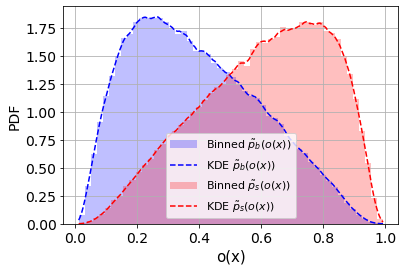

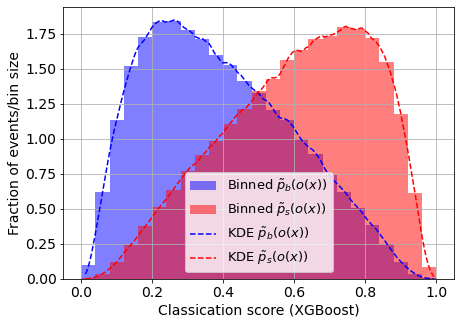

In [32]:
# USE KDE TO ESTIMATE THE CLASSIFIER OUTPUT PDFs



# # FIND THE BANDWIDTH

bandwidth = np.logspace(-4.0, 0.05, 20)

kde = KernelDensity(kernel='epanechnikov')
grid = GridSearchCV(kde, {'bandwidth': bandwidth})
grid.fit(np.c_[pred_XG_SM[:20000]])
print('Background: ', grid.best_estimator_)

SM_bandwidth = grid.best_estimator_.bandwidth



kde = KernelDensity(kernel='epanechnikov')
grid = GridSearchCV(kde, {'bandwidth': bandwidth})
grid.fit(np.c_[pred_XG_NP[:20000]])
print('Signal: ', grid.best_estimator_)

NP_bandwidth = grid.best_estimator_.bandwidth



# with each calculated bandwidth estimate the pdf with KDE to the classifier output (for background and signal)
# notice: epanechnikov kernel
kde_bkg = KernelDensity(kernel="epanechnikov", bandwidth=SM_bandwidth).fit(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ])
kde_sig = KernelDensity(kernel="epanechnikov", bandwidth=NP_bandwidth).fit(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ])



# range (~between 0 and 1)
min_val = np.min([np.min(pred_XG_SM),np.min(pred_XG_NP)])
max_val = np.max([np.max(pred_XG_SM),np.max(pred_XG_NP)])

s_vals = np.linspace(min_val,max_val,1000)



# evaluate the densities for each value of s (~bins)
dens_bkg = np.exp(kde_bkg.score_samples(np.c_[s_vals, np.zeros(len(s_vals)) ]) )
dens_sig = np.exp(kde_sig.score_samples(np.c_[s_vals, np.ones(len(s_vals)) ]) )



# Normalize to 1
# Area
factor_aux_SM = sum(dens_bkg*(s_vals[1]-s_vals[0]))
factor_aux_NP = sum(dens_sig*(s_vals[1]-s_vals[0]))

# normalize
dens_bkg = dens_bkg / factor_aux_SM
dens_sig = dens_sig / factor_aux_NP





# plot to check the estimation

plt.figure()

plt.hist(pred_XG_SM,density=True,bins=50,color='blue',alpha=0.25,label=r'Binned $\tilde{p}_{b}(o(x))$');
plt.plot(s_vals,dens_bkg,color='blue',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');

plt.hist(pred_XG_NP,density=True,bins=50,color='red',alpha=0.25,label=r'Binned $\tilde{p}_{s}(o(x))$');
plt.plot(s_vals,dens_sig,color='red',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("o(x)",fontsize=15)
plt.ylabel("PDF",fontsize=14)
plt.grid()
plt.legend(loc="lower center", fontsize=11, handlelength=2.5)
#plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
#plt.savefig('images/' + '2gaussian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()





plt.figure(figsize=(7,5))

nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 25, range=[0,1], density=True, color='blue',alpha=0.5, linewidth=2, label=r'Binned $\tilde{p}_{b}(o(x))$');
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 25, range=[0,1], density=True, color='red',alpha=0.5, linewidth=2, label=r'Binned $\tilde{p}_{s}(o(x))$');

plt.plot(s_vals,dens_bkg,color='blue',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');
plt.plot(s_vals,dens_sig,color='red',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.yscale('log')
plt.xlabel("Classication score (XGBoost)",fontsize=14)
plt.ylabel("Fraction of events/bin size",fontsize=14)
plt.grid()
plt.legend(loc='lower center',fontsize=13)
# plt.title(r'$m(LQ_3^u)=1.2$ TeV, $\beta=0.5$', fontsize=14)
# plt.savefig('XG_output.pdf', format="pdf", bbox_inches="tight")
plt.show()

### MLL+KDE test

In [ ]:
# FOR EXCLUSION:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

In [35]:
#################################################
# Uncertainties in tau pT using the dataset  #
#################################################

KDE_SM_pred_SM = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
KDE_NP_pred_SM = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )


# Normalize

KDE_SM_pred_SM = KDE_SM_pred_SM / factor_aux_SM
KDE_NP_pred_SM = KDE_NP_pred_SM / factor_aux_NP

B_expected:  50000
S_expected:  100
S/$\sqrt{B}$:  0.4472135954999579


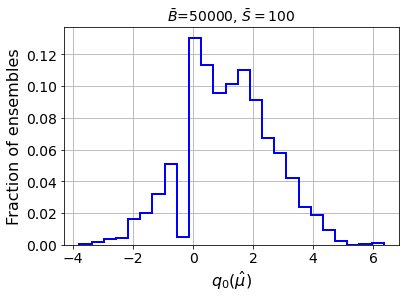

muhat mean:  0.099325
median q_muhat_KDE:  1.1914005232882374
Z_KDE:  1.0915129514981659
Z_KDE mu=0:  1.0915129514981659
std Z_KDE:  0.5509438030806612
std Z_KDE mu=0:  0.5556158585416496

 -------------------------------- 

B_expected:  50000
S_expected:  500
S/$\sqrt{B}$:  2.23606797749979


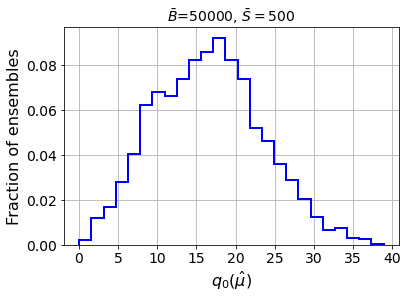

muhat mean:  0.07315
median q_muhat_KDE:  16.482788519080202
Z_KDE:  4.05990006269615
Z_KDE mu=0:  4.05990006269615
std Z_KDE:  0.8384733175327976
std Z_KDE mu=0:  0.8839622742438328

 -------------------------------- 

B_expected:  50000
S_expected:  1000
S/$\sqrt{B}$:  4.47213595499958


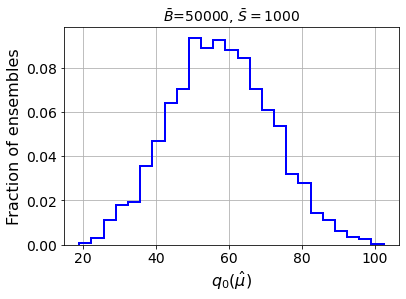

muhat mean:  0.042575
median q_muhat_KDE:  57.4884471130905
Z_KDE:  7.582113630979854
Z_KDE mu=0:  7.582113630979854
std Z_KDE:  0.9110539341191064
std Z_KDE mu=0:  0.941607101766645

 -------------------------------- 

[0.099325, 0.07315, 0.042575]
[1.0915129514981659, 4.05990006269615, 7.582113630979854]
[1.0915129514981659, 4.05990006269615, 7.582113630979854]
[0.5509438030806612, 0.8384733175327976, 0.9110539341191064]
[0.5556158585416496, 0.8839622742438328, 0.941607101766645]
[1.6424567545788271, 4.898373380228948, 8.493167565098961]
[0.5405691484175047, 3.2214267451633525, 6.671059696860747]


In [37]:
store_muhat_mean_MLL_KDE = []

store_Z_MLL_KDE = []
store_Z_MLL_KDE_mu0 = []

store_Z_MLL_KDE_std = []
store_Z_MLL_KDE_std_mu0 = []


indices = [i for i in range(len(KDE_NP_pred_SM))]


for iii in range(len(S_expected)):
    
    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected[iii])
    print(r'S/$\sqrt{B}$: ', SsqrtB[iii])
    
    #############################
    # NOW LETS APPLY THE METHOD #
    #############################
    
    muhat_selected_KDE_list = []
    q_muhat_KDE = []
    q_muhat_KDE_mu0 = []
    
    for its in range(n_ensembles):
        
        B_rand = np.random.poisson(int(B_expected))
#         S_rand = np.random.poisson(int(S_expected[iii]))

        N_rand = B_rand # for exclusion
#         N_rand = B_rand + S_rand # for discovery
        
        ran_ind = np.random.choice(indices, B_rand)

        KDE_SM_pred_SM_shuf = []
        KDE_NP_pred_SM_shuf = []

        for i in ran_ind:
            KDE_SM_pred_SM_shuf.append(KDE_SM_pred_SM[i])
            KDE_NP_pred_SM_shuf.append(KDE_NP_pred_SM[i])

        KDE_SM_pred_SM_shuf  = np.array(KDE_SM_pred_SM_shuf)
        KDE_NP_pred_SM_shuf  = np.array(KDE_NP_pred_SM_shuf)





        # p_b(o(x_ensemble)) =    concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble))  NOTICE THE o(x)
        prob_x_given_B = np.ndarray.tolist( KDE_SM_pred_SM_shuf ) #+ np.ndarray.tolist( KDE_SM_pred_NP_shuf )

        # p_s(o(x_ensemble)) =    concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble))  NOTICE THE o(x)
        prob_x_given_S = np.ndarray.tolist( KDE_NP_pred_SM_shuf ) #+ np.ndarray.tolist( KDE_NP_pred_NP_shuf )





        # NOW WE HAVE p_{s,b}(x_ensemble) for this particular ensemble
        # WE NEED TO ESTIMATE mu_hat for this particular ensemble
        # we are going to obtain a mu_hat with a grid of values for this particular ensemble

        B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]
            
        sum_muhat_zero = sum ( [(x*1.) / ( (x * 0. * S_expected[iii]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
        sum_muhat_one = sum ( [(x*1.) / ( (x * 1. * S_expected[iii]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

        # grid, mu_hat is around 1
        muhat_test = np.arange(0., 1., 0.05).tolist()

        muhat_selected_KDE = 0.0

        if sum_muhat_zero < sum_muhat_one and sum_muhat_zero < 1:

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected[iii]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 > 1:
                    muhat_selected_KDE = muhat_test[vv]
                    break

        elif sum_muhat_zero > sum_muhat_one and sum_muhat_zero > 1:

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected[iii]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 < 1:
                    muhat_selected_KDE = muhat_test[vv]
                    break


        muhat_selected_KDE_list.append(muhat_selected_KDE)



        # NOW THAT WE HAVE mu_hat FOR THIS ENSEMBLE, CALCULATE THE TEST STATISTIC FOR THIS ENSEMBLE
        # and append it (we need the median over lots of ensembles)
        #q_muhat.append( 2 * ( (-1.*muhat_selected * S_expected[iii]) + sum( [np.log( 1 + ( (muhat_selected*S_expected[iii]/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
        #q_muhat_mu0.append( 2 * ( (-1.*1. * S_expected[iii]) + sum( [np.log( 1 + ( (1.*S_expected[iii]/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
        # EXCLUSION:
        q_muhat_KDE.append( 2 * ( ( (1.-muhat_selected_KDE) * S_expected[iii] ) - sum( [np.log( ( (B_expected*y) + (S_expected[iii]*x) ) / ( (B_expected*y) + (muhat_selected_KDE*S_expected[iii]*x) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
        q_muhat_KDE_mu0.append( 2 * ( ( (1.-0.) * S_expected[iii] ) - sum( [np.log( ( (B_expected*y) + (S_expected[iii]*x) ) / ( (B_expected*y) + (0.*S_expected[iii]*x) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )


    # Histogram of q_muhats

    weights = np.ones_like(q_muhat_KDE)/float(len(q_muhat_KDE))
    nMIX, binsMIX, patchesMIX = plt.hist(q_muhat_KDE, 25, weights=weights, histtype='step', color='blue', linewidth=2)
    #plt.xlim(0,1)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
    plt.ylabel("Fraction of ensembles",fontsize=16)
    plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected[iii]),fontsize=14)
    plt.grid()
    #plt.legend(fontsize=14)
    plt.show()


    # Finally calculate muhat_mean and Z_gaussian
    
    # Remove nan if any
    q_muhat_KDE_mu0 = [x for x in q_muhat_KDE_mu0 if x == x]
    for jk in range(len(q_muhat_KDE_mu0)):
        if q_muhat_KDE_mu0[jk] < 0:
            q_muhat_KDE_mu0[jk] = 0

    q_muhat_KDE_median_mu0 = np.median(q_muhat_KDE_mu0)
    Z_KDE_mu0 = abs(q_muhat_KDE_median_mu0)**0.5
    store_Z_MLL_KDE_mu0.append(Z_KDE_mu0)
    
    q_muhat_KDE_std_mu0 = np.std(q_muhat_KDE_mu0)
    Z_KDE_std_mu0 = q_muhat_KDE_std_mu0/(2.*Z_KDE_mu0)
    store_Z_MLL_KDE_std_mu0.append(Z_KDE_std_mu0)
    

    # Finally calculate muhat_mean and Z_gaussian
    muhat_mean_MLL_KDE = np.mean(muhat_selected_KDE_list)
    store_muhat_mean_MLL_KDE.append(muhat_mean_MLL_KDE)

    # Remove nan if any
    q_muhat_KDE = [x for x in q_muhat_KDE if x == x]
    for jk in range(len(q_muhat_KDE)):
        if q_muhat_KDE[jk] < 0:
            q_muhat_KDE[jk] = 0

    q_muhat_KDE_median = np.median(q_muhat_KDE)
    Z_KDE = abs(q_muhat_KDE_median)**0.5
    store_Z_MLL_KDE.append(Z_KDE)
    
    q_muhat_KDE_std = np.std(q_muhat_KDE)
    Z_KDE_std = q_muhat_KDE_std/(2.*Z_KDE)
    store_Z_MLL_KDE_std.append(Z_KDE_std)

    print('muhat mean: ', muhat_mean_MLL_KDE)
    print('median q_muhat_KDE: ', q_muhat_KDE_median)
    print('Z_KDE: ', Z_KDE)
    print('Z_KDE mu=0: ', Z_KDE_mu0)
    print('std Z_KDE: ', Z_KDE_std)
    print('std Z_KDE mu=0: ', Z_KDE_std_mu0)

    print('\n -------------------------------- \n')
    
    
print(store_muhat_mean_MLL_KDE)

print(store_Z_MLL_KDE)
print(store_Z_MLL_KDE_mu0)

print(store_Z_MLL_KDE_std)
print(store_Z_MLL_KDE_std_mu0)


print(' ')
store_Z_MLL_KDE_plus = [i+j for i, j in zip(store_Z_MLL_KDE, store_Z_MLL_KDE_std)]
store_Z_MLL_KDE_min = [i-j for i, j in zip(store_Z_MLL_KDE, store_Z_MLL_KDE_std)]

print(store_Z_MLL_KDE_plus)
print(store_Z_MLL_KDE_min)


print(' ')
store_Z_MLL_KDE_mu0_plus = [i+j for i, j in zip(store_Z_MLL_KDE_mu0, store_Z_MLL_KDE_std_mu0)]
store_Z_MLL_KDE_mu0_min = [i-j for i, j in zip(store_Z_MLL_KDE_mu0, store_Z_MLL_KDE_std_mu0)]

print(store_Z_MLL_KDE_mu0_plus)
print(store_Z_MLL_KDE_mu0_min)

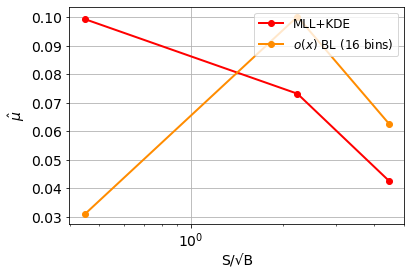

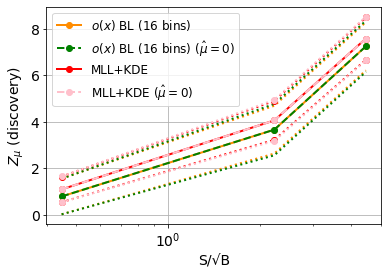

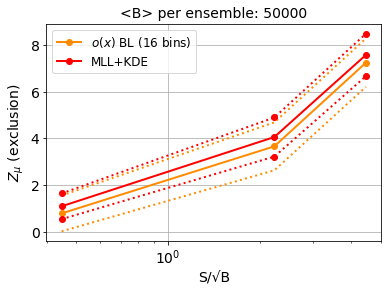

In [42]:
#########
# PLOTS #
#########


plt.figure()
lw = 2

plt.plot(SsqrtB, store_muhat_mean_MLL_KDE, '-o', color='red', lw=lw, label='MLL+KDE')
plt.plot(SsqrtB, store_muhat_mean_16bins_q, '-o', color='darkorange', lw=lw, label=r'$o(x)$ BL (16 bins)')

#plt.xlim([0.5, 100])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=14)
plt.ylabel(r'$\hat{\mu}$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
#plt.title('Gaussian Example, <B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper right", fontsize=12)
plt.show()




plt.figure()
lw = 2

plt.plot(SsqrtB, store_Z_bins_XG_16bins_q, '-o', color='darkorange', lw=lw, label=r'$o(x)$ BL (16 bins)') 
plt.plot(SsqrtB, store_Z_bins_XG_16bins_q_plus, ':', color='darkorange', lw=lw) 
plt.plot(SsqrtB, store_Z_bins_XG_16bins_q_min, ':', color='darkorange', lw=lw)
plt.plot(SsqrtB, store_Z_bins_XG_16bins_q_mu0, '--o', color='green', lw=lw, label=r'$o(x)$ BL (16 bins) ($\hat{\mu}=0$)') 
plt.plot(SsqrtB, store_Z_bins_XG_16bins_q_mu0_plus, ':', color='green', lw=lw) 
plt.plot(SsqrtB, store_Z_bins_XG_16bins_q_mu0_min, ':', color='green', lw=lw)
plt.plot(SsqrtB, store_Z_MLL_KDE, '-o', color='red', lw=lw, label='MLL+KDE')
plt.plot(SsqrtB, store_Z_MLL_KDE_plus, ':o', color='red', lw=lw)
plt.plot(SsqrtB, store_Z_MLL_KDE_min, ':o', color='red', lw=lw)
plt.plot(SsqrtB, store_Z_MLL_KDE_mu0, '--o', color='pink', lw=lw, label=r'MLL+KDE ($\hat{\mu}=0$)')
plt.plot(SsqrtB, store_Z_MLL_KDE_mu0_plus, ':o', color='pink', lw=lw)
plt.plot(SsqrtB, store_Z_MLL_KDE_mu0_min, ':o', color='pink', lw=lw)

#plt.xlim([0.5, 10])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=14)
plt.ylabel('$Z_{\mu}$ (discovery)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
#plt.title('Gaussian Example, <B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()




plt.figure()
lw = 2

plt.plot(SsqrtB, store_Z_bins_XG_16bins_q, '-o', color='darkorange', lw=lw, label=r'$o(x)$ BL (16 bins)') 
plt.plot(SsqrtB, store_Z_bins_XG_16bins_q_plus, ':', color='darkorange', lw=lw) 
plt.plot(SsqrtB, store_Z_bins_XG_16bins_q_min, ':', color='darkorange', lw=lw) 
plt.plot(SsqrtB, store_Z_MLL_KDE, '-o', color='red', lw=lw, label='MLL+KDE')
plt.plot(SsqrtB, store_Z_MLL_KDE_plus, ':o', color='red', lw=lw)
plt.plot(SsqrtB, store_Z_MLL_KDE_min, ':o', color='red', lw=lw)

#plt.xlim([0.5, 10])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=14)
plt.ylabel('$Z_{\mu}$ (exclusion)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.title('<B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()